In [47]:
import pandas as pd, numpy as np, math, json
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

DF_PATH = "bechdel_enriched_with_gender.csv" 
df = pd.read_csv(DF_PATH)

In [63]:
import json
from pathlib import Path
import numpy as np
import math

def write_wp_snippet_plain(
    fig,
    out_path,
    div_id,
    height=520,
    plotly_cdn="https://cdn.plot.ly/plotly-2.35.2.min.js",
):

    def clean(obj):
        # None stays None
        if obj is None:
            return None

        if isinstance(obj, (np.bool_,)):
            return bool(obj)
        if isinstance(obj, (np.integer,)):
            return int(obj)
        if isinstance(obj, (np.floating,)):
            x = float(obj)
            return None if (math.isnan(x) or math.isinf(x)) else x

        if isinstance(obj, float):
            return None if (math.isnan(obj) or math.isinf(obj)) else obj

        if isinstance(obj, np.ndarray):
            return [clean(v) for v in obj.tolist()]

        if isinstance(obj, (list, tuple)):
            return [clean(v) for v in obj]

        if isinstance(obj, dict):

            return {k: clean(v) for k, v in obj.items()}

        return obj

    dct = clean(fig.to_dict())

    if isinstance(dct, dict) and "layout" in dct and isinstance(dct["layout"], dict):
        dct["layout"].pop("template", None)
        # Ensure explicit height so WP containers don't squash it
        dct["layout"]["height"] = int(height)

    data_json = json.dumps(dct.get("data", []), separators=(",", ":"))
    layout_json = json.dumps(dct.get("layout", {}), separators=(",", ":"))

    html = f"""
<div id="{div_id}" style="width:100%;height:{height}px;"></div>
<script>
(function(){{
  var _data = {data_json};
  var _layout = {layout_json};
  var _config = {{responsive:true,displaylogo:false}};

  function draw(){{
    var el = document.getElementById("{div_id}");
    if(!el) return setTimeout(draw, 30);
    if(!window.Plotly) return setTimeout(draw, 50);
    try {{
      Plotly.newPlot(el, _data, _layout, _config);
    }} catch(e) {{
      console.error("Plotly render error:", e);
    }}
  }}

  // If Plotly isn't loaded, inject it once, then render
  if(!window.Plotly){{
    if(!document.getElementById("plotly-cdn-loader")){{
      var s = document.createElement("script");
      s.id = "plotly-cdn-loader";
      s.src = "{plotly_cdn}";
      s.onload = draw;
      document.head.appendChild(s);
    }} else {{
      setTimeout(draw, 100);
    }}
  }} else {{
    draw();
  }}

  if(document.readyState === "loading") {{
    document.addEventListener("DOMContentLoaded", draw);
  }}
}})();
</script>
""".strip()

    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    Path(out_path).write_text(html, encoding="utf-8")
    print("Wrote:", out_path)


In [64]:
import pandas as pd, numpy as np, re

df = df.copy()

def first_present(cols):
    for c in cols:
        if c in df.columns:
            return c
    return None

ycol = first_present(["year_int","year","year_final"])
year_series = pd.to_numeric(df[ycol], errors="coerce") if ycol else pd.Series(np.nan, index=df.index)
dec_start = (year_series // 10) * 10
df["decade"] = dec_start.astype("Int64").astype("string") + "s"

s = pd.to_numeric(df[first_present(["binary"])], errors="coerce") if first_present(["binary"]) else pd.Series(np.nan, index=df.index)
if first_present(["bechdel_pass"]):
    m = s.isna()
    map_bp = df["bechdel_pass"].astype(str).str.lower().map({"pass":1,"fail":0,"yes":1,"no":0,"1":1,"0":0})
    s = s.where(~m, map_bp)
if first_present(["clean_test"]):
    m = s.isna()
    ct = df["clean_test"].astype(str).str.lower()
    s = s.where(~m, np.where(ct.str.startswith("ok"), 1, np.where(ct.isin(["men","nowomen","notalk","dubious"]), 0, np.nan)))
if first_present(["test"]):
    m = s.isna()
    tt = df["test"].astype(str).str.lower()
    s = s.where(~m, tt.map({"ok":1,"men":0,"nowomen":0,"notalk":0,"dubious":0}))
df["bechdel_pass_bin"] = pd.to_numeric(s, errors="coerce").fillna(0).astype(int)

osc_nom_col = first_present(["osc_nominations","oscar_nominations","osc_nom","oscars_nominated"])
df["_osc_noms_num"] = pd.to_numeric(df[osc_nom_col], errors="coerce").fillna(0) if osc_nom_col else 0
osc_win_col = first_present(["osc_wins","oscar_wins"])
df["_osc_wins_num"] = pd.to_numeric(df[osc_win_col], errors="coerce").fillna(0) if osc_win_col else 0

pc_col = first_present(["production_company","production_companies","production_companies_names","production_companies_list"])
if pc_col:
    pc_vals = df[pc_col].astype(str)
    pc_vals = pc_vals.str.replace(r"^\[|\]$","",regex=True).str.replace("'", "", regex=False)
    df["production_company_norm"] = pc_vals.str.split("[|,]").str[0].str.strip().replace({"":np.nan})
else:
    df["production_company_norm"] = np.nan

bcol = first_present(["budget_2013$","budget_adj","budget"])
dgcol = first_present(["domgross_2013$","domgross_adj","domgross"])
igcol = first_present(["intgross_2013$","intgross_adj","intgross"])
budget = pd.to_numeric(df[bcol], errors="coerce") if bcol else np.nan
dom = pd.to_numeric(df[dgcol], errors="coerce") if dgcol else 0
intl = pd.to_numeric(df[igcol], errors="coerce") if igcol else 0
world = pd.Series(dom, index=df.index).add(pd.Series(intl, index=df.index), fill_value=0)
df["_roi"] = np.where((pd.notna(budget)) & (budget>0), world / budget, np.nan)

fcast = pd.to_numeric(df[first_present(["female_cast_ratio","female_cast_pct"])], errors="coerce") if first_present(["female_cast_ratio","female_cast_pct"]) else np.nan
fcrew = pd.to_numeric(df[first_present(["female_crew_ratio","female_crew_pct"])], errors="coerce") if first_present(["female_crew_ratio","female_crew_pct"]) else np.nan
df["female_cast_ratio"] = fcast
df["female_crew_ratio"] = fcrew

gcol = first_present(["genre","genres","Genre"])
if gcol:
    _g = df[[gcol,"bechdel_pass_bin"]].copy()
    _g[gcol] = _g[gcol].astype(str)
    _g = _g.assign(_list=_g[gcol].str.split(",")).explode("_list", ignore_index=True)
    _g["_list"] = _g["_list"].str.strip()
    _g = _g[_g["_list"].ne("")]
else:
    _g = pd.DataFrame(columns=["_list","bechdel_pass_bin"])

df["_imdb_rating"] = pd.to_numeric(df[first_present(["imdb_rating","avg_vote","imdb_score"])], errors="coerce") if first_present(["imdb_rating","avg_vote","imdb_score"]) else np.nan
df["_imdb_votes"]  = pd.to_numeric(df[first_present(["imdb_votes","votes"])], errors="coerce") if first_present(["imdb_votes","votes"]) else np.nan
df["_runtime"]     = pd.to_numeric(df[first_present(["runtime_minutes","duration"])], errors="coerce") if first_present(["runtime_minutes","duration"]) else np.nan
df["_cast_count"]  = pd.to_numeric(df[first_present(["cast_count"])], errors="coerce") if first_present(["cast_count"]) else np.nan
df["_crew_count"]  = pd.to_numeric(df[first_present(["crew_count"])], errors="coerce") if first_present(["crew_count"]) else np.nan
df["_budget"]      = pd.to_numeric(df[bcol], errors="coerce") if bcol else np.nan
df["_domgross"]    = pd.to_numeric(df[dgcol], errors="coerce") if dgcol else np.nan
df["_intgross"]    = pd.to_numeric(df[igcol], errors="coerce") if igcol else np.nan

decade_stats = (
    df.dropna(subset=["decade"])
      .groupby("decade", dropna=True)
      .agg(
          pass_rate=("bechdel_pass_bin","mean"),
          oscar_rate=("_osc_noms_num", lambda x: (x>0).mean())
      )
      .reset_index()
)
decade_stats["pass_rate"] = (decade_stats["pass_rate"]*100).round(2)
decade_stats["oscar_rate"] = (decade_stats["oscar_rate"]*100).round(2)
try:
    decade_stats["_d"] = decade_stats["decade"].str.rstrip("s").astype(int)
    decade_stats = decade_stats.sort_values("_d").drop(columns="_d")
except:
    pass

studio_pass = (
    df.dropna(subset=["production_company_norm"])
      .groupby("production_company_norm")["bechdel_pass_bin"]
      .mean().mul(100).reset_index(name="pass_pct")
      .sort_values("pass_pct", ascending=False)
      .rename(columns={"production_company_norm":"production_company"})
)

osc = (
    df.dropna(subset=["production_company_norm"])
      .groupby("production_company_norm")[["bechdel_pass_bin","_osc_wins_num"]]
      .mean().reset_index()
      .rename(columns={"production_company_norm":"production_company","_osc_wins_num":"osc_wins"})
)
osc["binary"] = (osc["bechdel_pass_bin"]*100).round(2)

g = (
    df.dropna(subset=["production_company_norm"])
      .groupby("production_company_norm")
      .agg(pass_rate=("bechdel_pass_bin","mean"), avg_roi=("_roi","mean"))
      .dropna()
      .reset_index()
      .rename(columns={"production_company_norm":"production_company"})
)
g["pass_rate"] = (g["pass_rate"]*100).round(2)

genre_trend = (
    _g.groupby("_list")["bechdel_pass_bin"]
      .mean().mul(100).reset_index(name="pass_pct")
      .sort_values("pass_pct", ascending=False)
      .rename(columns={"_list":"genre"})
)

crew_corr = df[["female_crew_ratio","female_cast_ratio"]].apply(pd.to_numeric, errors="coerce").dropna()

numeric_cols = [
    "_roi","_imdb_rating","_imdb_votes","_runtime",
    "female_cast_ratio","female_crew_ratio","_cast_count","_crew_count",
    "_osc_wins_num","_osc_noms_num","_budget","_domgross","_intgross"
]
present = [c for c in numeric_cols if c in df.columns]
corr = df[present].corr().round(2)

print("decade_stats rows:", len(decade_stats))
print("studio_pass rows:", len(studio_pass))
print("osc rows:", len(osc))
print("g rows:", len(g))
print("genre_trend rows:", len(genre_trend))
print("crew_corr rows:", len(crew_corr))
print("corr shape:", corr.shape)


decade_stats rows: 5
studio_pass rows: 537
osc rows: 537
g rows: 529
genre_trend rows: 21
crew_corr rows: 1653
corr shape: (13, 13)


In [65]:
# Rebuild bechdel_pass_bin from clean_test / test
df["bechdel_pass_bin"] = df["clean_test"].astype(str).str.lower().map(
    {"ok": 1, "notalk": 0, "men": 0, "nowomen": 0, "dubious": 0}
)

df.loc[df["bechdel_pass_bin"].isna(), "bechdel_pass_bin"] = df["test"].astype(str).str.lower().apply(
    lambda x: 1 if x.startswith("ok") else 0
)

df["bechdel_pass_bin"] = df["bechdel_pass_bin"].astype(int)

print(df["bechdel_pass_bin"].value_counts(normalize=True))


bechdel_pass_bin
0    0.552397
1    0.447603
Name: proportion, dtype: float64


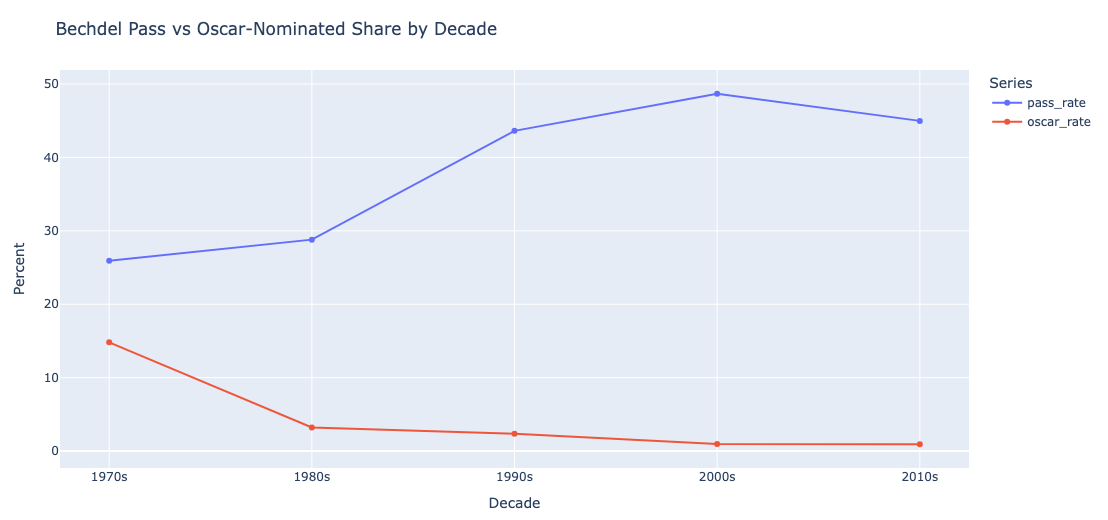

In [66]:

fig = px.line(
    decade_stats, x="decade", y=["pass_rate","oscar_rate"],
    markers=True,
    title="Bechdel Pass vs Oscar-Nominated Share by Decade",
    labels={"decade":"Decade","value":"Percent","variable":"Series"}
)
fig.update_layout(margin=dict(l=60,r=20,t=70,b=40), height=520)
fig.show()

#write_wp_snippet_plain(fig, "01_line_chart.html", "01_line_chart")

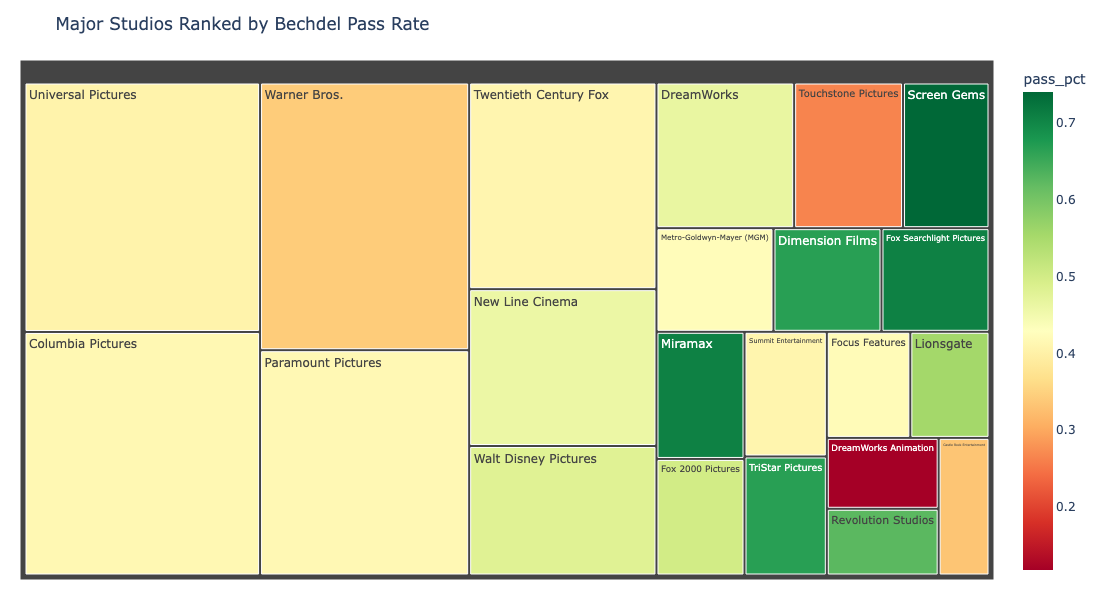

Wrote: 02_tree_map.html


In [67]:
studio_pass = (
    df.groupby("production_company")
      .agg(pass_pct=("bechdel_pass_bin","mean"), film_count=("title","count"))
      .reset_index()
)

studio_pass = studio_pass[studio_pass["film_count"] >= 15]  # filter small studios

fig = px.treemap(
    studio_pass,
    path=["production_company"],
    values="film_count",
    color="pass_pct",
    color_continuous_scale="RdYlGn",
    title="Major Studios Ranked by Bechdel Pass Rate"
)
fig.update_layout(margin=dict(l=20,r=20,t=60,b=20), height=600)
fig.show()
write_wp_snippet_plain(fig, "02_tree_map.html", "02_tree_map.html")

In [53]:
studio_metrics = (
    df.groupby("production_company")
      .agg(
          film_count=("title", "count"),
          pass_rate=("bechdel_pass_bin", "mean"),
          nom_rate=("osc_nominations", lambda x: (x > 0).mean()),
          win_rate=("osc_wins", lambda x: (x > 0).mean())
      )
      .reset_index()
)

studio_metrics["pass_rate"] *= 100
studio_metrics["nom_rate"] *= 100
studio_metrics["win_rate"] *= 100


In [ ]:
import pandas as pd
import numpy as np

title_col = "title" if "title" in df.columns else ("original_title" if "original_title" in df.columns else "imdb_title_id")
prod_col  = "production_company" if "production_company" in df.columns else "production_company_norm"

studio_metrics = (
    df.dropna(subset=[prod_col])
      .groupby(prod_col)
      .agg(
          film_count=(title_col, "count"),
          pass_rate=("bechdel_pass_bin", "mean"),
          nom_rate=("_osc_noms_num", lambda x: (x > 0).mean()),
          win_rate=("_osc_wins_num",  lambda x: (x > 0).mean()),
          avg_wins=("_osc_wins_num", "mean")
      )
      .reset_index()
      .rename(columns={prod_col: "production_company"})
)

studio_metrics["pass_rate"] = (studio_metrics["pass_rate"]*100).round(2)
studio_metrics["nom_rate"]  = (studio_metrics["nom_rate"]*100).round(2)
studio_metrics["win_rate"]  = (studio_metrics["win_rate"]*100).round(2)


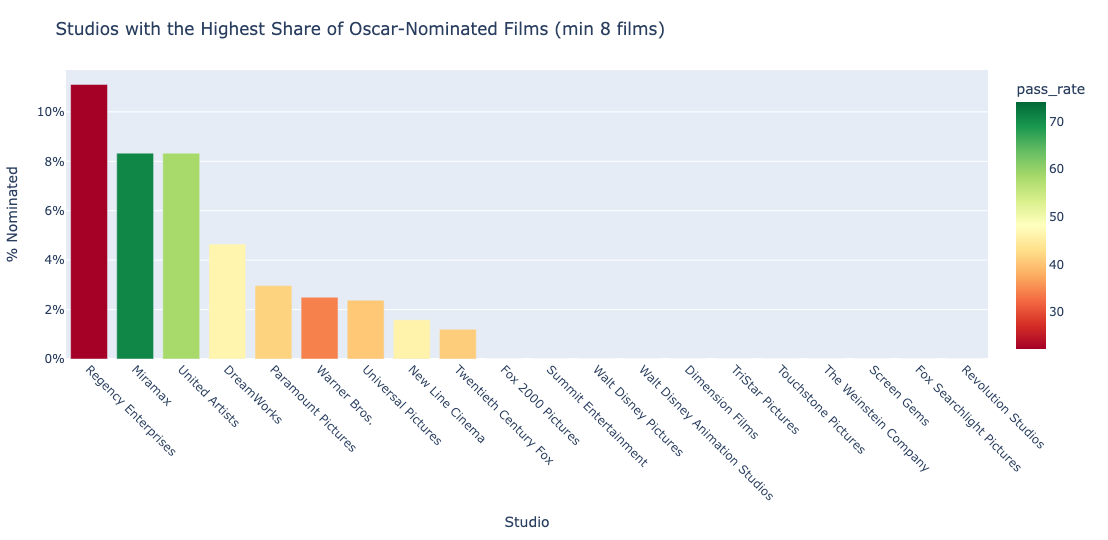

Wrote: 03_bar_chart.html


In [68]:
import plotly.express as px

top20 = (studio_metrics
         .query("film_count >= 8")
         .sort_values("nom_rate", ascending=False)
         .head(20))

fig2 = px.bar(
    top20,
    x="production_company", y="nom_rate",
    color="pass_rate", color_continuous_scale="RdYlGn",
    hover_data=["film_count","win_rate","avg_wins"],
    title="Studios with the Highest Share of Oscar-Nominated Films (min 8 films)"
)
fig2.update_layout(
    xaxis_title="Studio", yaxis_title="% Nominated",
    yaxis=dict(ticksuffix="%", rangemode="tozero"),
    xaxis_tickangle=45, height=540,
    margin=dict(l=60,r=20,t=70,b=90)
)
fig2.show()
write_wp_snippet_plain(fig2, "03_bar_chart.html", "03_bar_chart.html")

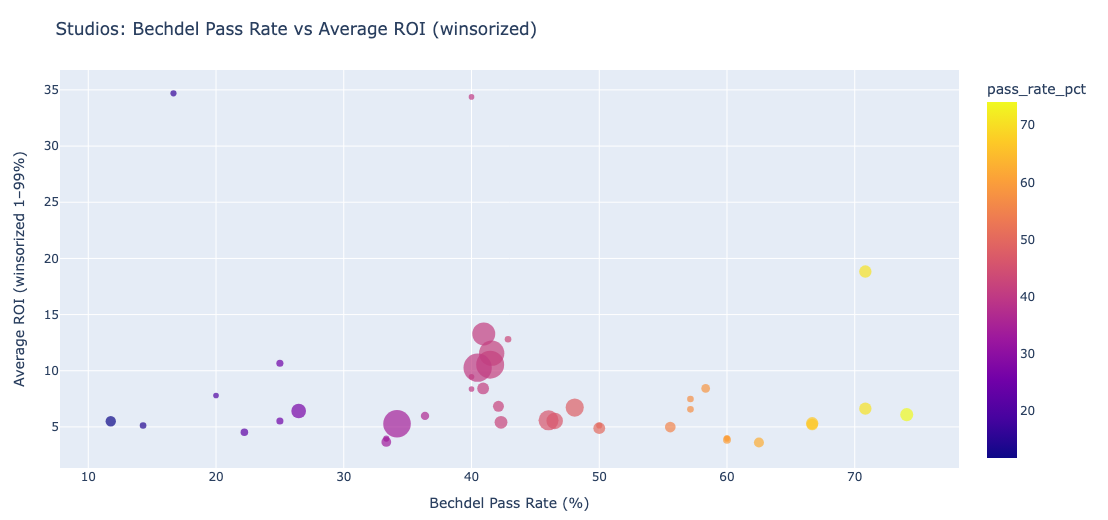

Wrote: wp_snippets/04_scatter_roi_clean.html


In [ ]:

title_col = "title" if "title" in df.columns else ("original_title" if "original_title" in df.columns else "imdb_title_id")
prod_col  = "production_company" if "production_company" in df.columns else "production_company_norm"

studio_roi = (
    df.dropna(subset=[prod_col])
      .groupby(prod_col)
      .agg(
          film_count=(title_col, "count"),
          pass_rate=("bechdel_pass_bin", "mean"),
          avg_roi=("_roi", "mean")
      )
      .reset_index()
      .rename(columns={prod_col: "production_company"})
)

# percentages
studio_roi["pass_rate_pct"] = (studio_roi["pass_rate"]*100).round(2)

# filter + winsorize ROI to tame extreme values
plot_df = studio_roi.dropna(subset=["avg_roi"]).query("film_count >= 5").copy()
q1, q99 = plot_df["avg_roi"].quantile([0.01, 0.99])
plot_df["avg_roi_ws"] = plot_df["avg_roi"].clip(q1, q99)

# scatter (no text labels; hover only)
fig = px.scatter(
    plot_df,
    x="pass_rate_pct", y="avg_roi_ws",
    size="film_count", color="pass_rate_pct",
    color_continuous_scale="Plasma",
    hover_name="production_company",
    hover_data={"film_count":True, "avg_roi":":.1f", "avg_roi_ws":":.1f", "pass_rate_pct":":.1f"},
    title="Studios: Bechdel Pass Rate vs Average ROI (winsorized)"
)
fig.update_traces(marker=dict(opacity=0.7, line=dict(width=0)))
fig.update_layout(
    xaxis_title="Bechdel Pass Rate (%)",
    yaxis_title="Average ROI (winsorized 1–99%)",
    margin=dict(l=60,r=20,t=70,b=50),
    height=520,
    showlegend=False
)


fig.show()

write_wp_snippet_plain(fig, "wp_snippets/04_scatter_roi_clean.html", "scatter-roi-clean")


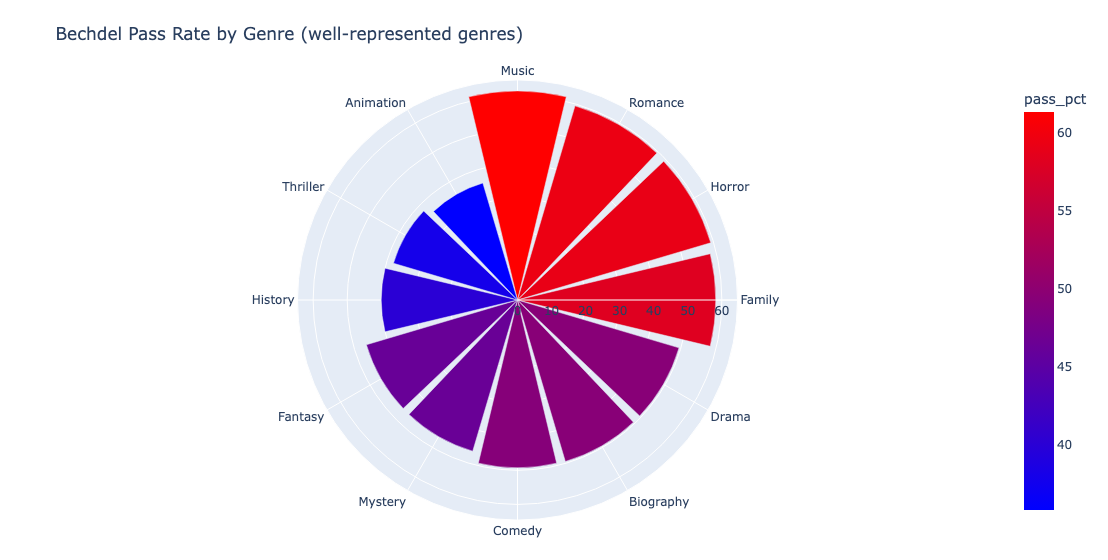

Wrote: wp_snippets/05_bar_polar.html


In [ ]:
genre_counts = _g.groupby("_list").size().reset_index(name="n").rename(columns={"_list":"genre"})

plot_df = (genre_trend.merge(genre_counts, on="genre", how="left")
                     .query("n >= 30")                # adjust threshold if needed
                     .sort_values("pass_pct", ascending=False)
                     .head(12))

fig = px.bar_polar(
    plot_df,
    r="pass_pct",
    theta="genre",
    color="pass_pct",
    color_continuous_scale="Bluered",
    title="Bechdel Pass Rate by Genre (well-represented genres)"
)
fig.update_layout(height=560, margin=dict(l=40,r=40,t=80,b=40))
fig.show()
write_wp_snippet_plain(fig, "wp_snippets/05_bar_polar.html", "05-bar-polar")

In [ ]:
# === Chart 7: Correlation heatmap ===
fig = go.Figure(go.Heatmap(
    z=corr.values.tolist(), x=corr.columns.tolist(), y=corr.index.tolist(),
    zmin=-1, zmax=1, zmid=0,
    colorscale="RdBu", reversescale=True,
    hovertemplate="x: %{x}<br>y: %{y}<br>r: %{z:.2f}<extra></extra>"
))
ann = []
for i, y in enumerate(corr.index):
    for j, x in enumerate(corr.columns):
        val = corr.iloc[i,j]
        ann.append(dict(x=x, y=y, text=f"{val:.2f}", showarrow=False,
                        font=dict(color=("white" if abs(val) > 0.45 else "black"), size=12)))
fig.update_layout(
    title="Correlation Heatmap: Representation, Money and Recognition",
    xaxis=dict(side="top", tickangle=35, automargin=True),
    yaxis=dict(autorange="reversed", automargin=True),
    annotations=ann, height=520, margin=dict(l=80,r=40,t=80,b=80)
)
write_wp_snippet_plain(fig, "wp_snippets/06_corr_heatmap.html", "06-corr-heatmap")


Wrote: wp_snippets/06_corr_heatmap.html
